<div class="alert alert-block alert-warning">
<b>Disclaimer:</b> The main objective of the jupyter notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function
- setting and run the fit   
- extracting and displaying information about the results

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
</div>

<h1> Example: Brownian Translational diffusion model convoluted with resolution function and fitted with bumps </h1>

<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#setting_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the <b>Brownian Translational diffusion</b> model to perform some 
fits using <a href="https://github.com/bumps/bumps">bumps</a> .
</div>

The **reference data** were generated data corresponding to a Brownian Translational diffusion model with self-diffusion coefficient = 0.145 &#x212B;$^2\times$meV.

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

The data do not have a background.

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'D': "meV.Angstrom^2", 
                       'scale': "unit_of_signal.meV", 
                       'center': "meV"}

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [2]:
# Imported required libraries
from __future__ import print_function
import sys
import os

# for interactive plots
import panel
panel.extension()
import panel.widgets as pnw

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    bumpsY = pnw.Button(name='Yes', button_type='success')
    bumpsN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install bumps?", panel.Row(bumpsY, bumpsN))
    display(choice_installation)

Column
    [0] Markdown(str)
    [1] Row
        [0] Button(button_type='success', name='Yes')
        [1] Button(button_type='danger', name='No')

In [4]:
if not pkgutil.find_loader("bumps"):
    if bumpsY.clicks>0:
        !{sys.executable} -m pip install bumps
    elif bumpsN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

     |████████████████████████████████| 512kB 3.0MB/s eta 0:00:01
  Created wheel for bumps: filename=bumps-0.7.12-cp37-none-any.whl size=539803 sha256=be880a4948efd93d23a72baa451c5cf642174ba08d2bcbc0db5683dcdd9ffffa
  Stored in directory: /Users/celinedurniak/Library/Caches/pip/wheels/1e/99/a6/3561f77821bb128960fdad2d013f17d1950e41a301441f3178
Successfully built bumps


In [5]:
import bumps

In [6]:
# check version of bumps installed
# Information message if installed version not recent enough
from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> install QENSmodels (if not already installed) </h3>

In [7]:
if not pkgutil.find_loader("QENSmodels"):
    buttonY = pnw.Button(name='Yes', button_type='success')
    buttonN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install the QENSmodels' library?", panel.Row(buttonY, buttonN))
    display(choice_installation)

In [8]:
if not pkgutil.find_loader("QENSmodels"):
    if buttonY.clicks>0:
        !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels
    elif buttonN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

<h3> import reference data </h3>

In [9]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty_pm

path_to_data = './data/'

# Read the sample
with h5py.File(path_to_data + 'BrownianDiff_Sample.hdf', 'r') as f:
    hw = f['entry1']['data1']['X'][:]
    q = f['entry1']['data1']['Y'][:]
    unit_w=f['entry1']['data1']['X'].attrs['long_name']
    unit_q=f['entry1']['data1']['Y'].attrs['long_name']
    sqw = np.transpose(f['entry1']['data1']['DATA'][:])
    err = np.transpose(f['entry1']['data1']['errors'][:])

# Read resolution
with h5py.File(path_to_data + 'BrownianDiff_Resol.hdf', 'r') as f:
    res = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

<h3> display units of input data </h3>
Just for information in order to determine if a convertion of units is required before using the QENSmodels

In [10]:
print("The names and units of `w` ( `x`axis) and `q` are: {} and {}, respectively.".format(str(unit_w[0], 'utf-8'), str(unit_q[0], 'utf-8')))

The names and units of `w` ( `x`axis) and `q` are: X and Y, respectively.


<h3> create fitting model </h3>

In [11]:
# Fitting model 
def model_convol(x, q, scale=1, center=0, D=1, resolution=None):
    model = QENSmodels.sqwBrownianTranslationalDiffusion(x, q, scale, center, D)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

for i in range(len(q)):
    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, D=0.1, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.D.range(0,1)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D  
    else:
        Mq.D = QD
    M.append(Mq)
        
problem = FitProblem(M)

In [12]:
problem.summarize()

'                                       D |.........        0.1 in (0,1)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0

<h3> Choice of minimizer for bumps </h3>

In [13]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer= pnw.Select(name='Minimizer:', options=list(options_dict.keys()), value='Levenberg-Marquardt')

w_choice_minimizer

Select(name='Minimizer:', options=['Levenberg-Marquardt', ...], value='Levenberg-Marquardt')

<h3> Setting for running bumps </h3>

In [14]:
steps_fitting = pnw.TextInput(
        placeholder='number of steps when fitting',
        width=250,
        name='Number of steps for fit:', value='100')
steps_fitting

TextInput(name='Number of steps f..., placeholder='number of steps w..., value='100', width=250)

In [15]:
# Input chosen values to related fitting variables
# CHOICE OF MINIMIZER
chosen_minimizer = options_dict[w_choice_minimizer.value]

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = int(steps_fitting.value)

Initial chisq 502.4650(59)


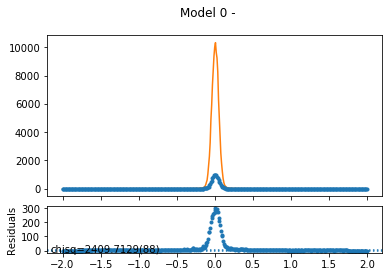

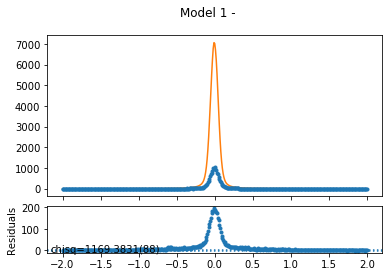

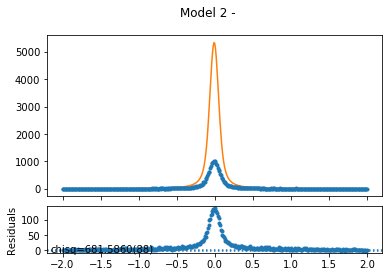

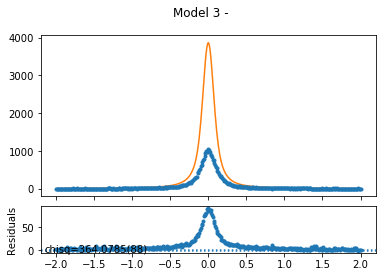

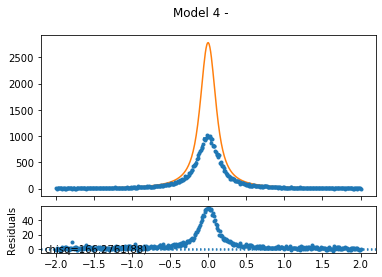

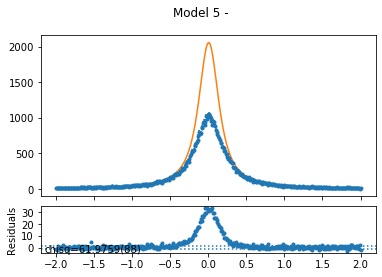

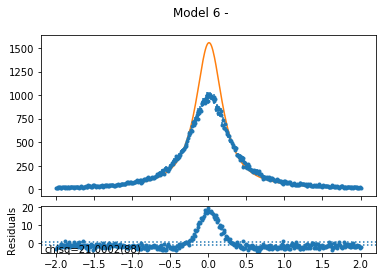

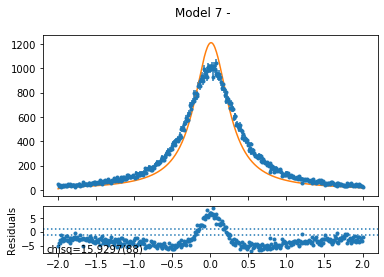

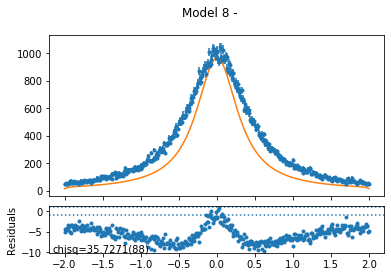

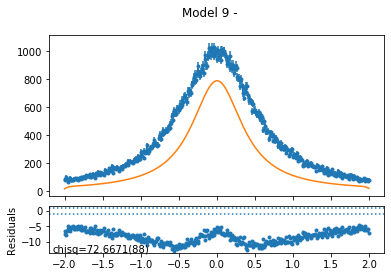

In [16]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())

problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above

In [17]:
result = fit(problem, 
             method=chosen_minimizer, 
             steps=steps, 
             verbose=True)

final chisq 0.9996(59)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                                       D 0.14413(29)     0.14413(29)    
                                  center -0.48(55)e-3    -0.48(55)e-3   
                                   scale 110.9(12)       110.9(12)      
                                  center 0.35(55)e-3     0.35(55)e-3    
                                   scale 155.0(13)       155.0(13)      
                                  center -0.95(67)e-3    -0.95(67)e-3   
                                   scale 229.0(15)       229.0(15)      
                                  center -0.31(90)e-3    -0.31(90)e-3   
                                   scale 332.6(19)       332.6(19)      
                                  center 0.1(11)e-3      0.1(11)e-3     
                                   scale 484.2(23)       484.2(23)      
                                  center 0.7(11)e-3      0.7(11)e-3     
                       

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

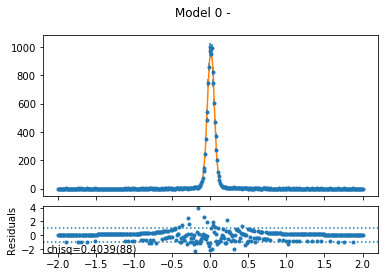

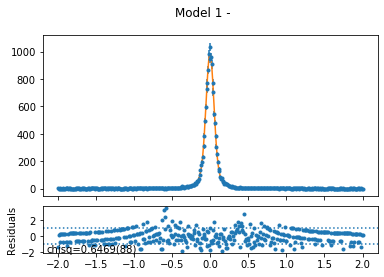

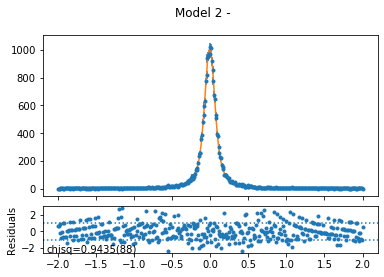

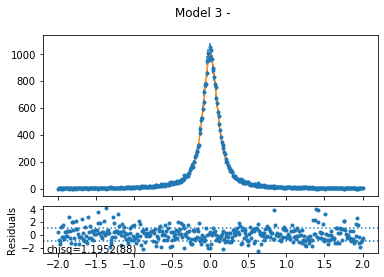

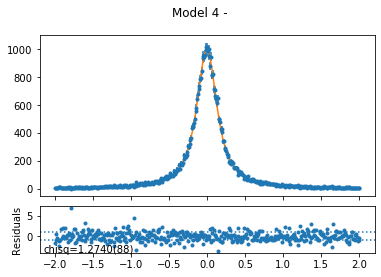

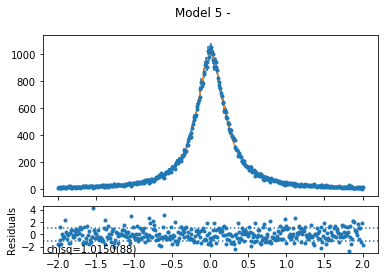

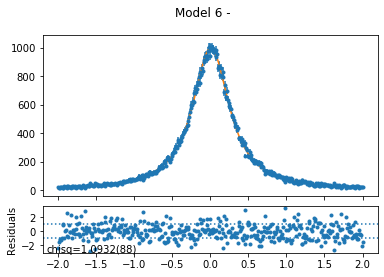

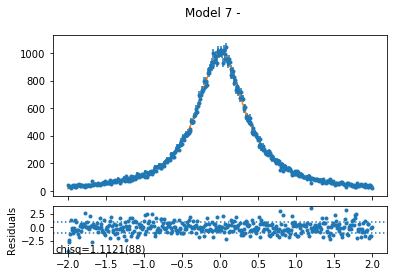

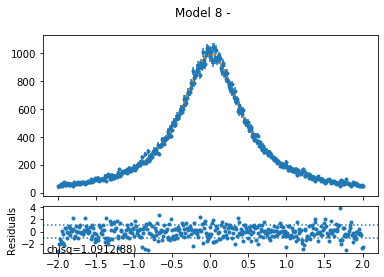

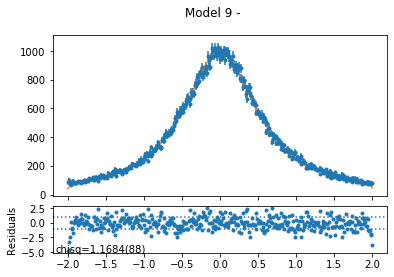

In [18]:
problem.plot()

In [19]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    if k in dict_physical_units.keys():
        print(k, ":", format_uncertainty_pm(v, dv), dict_physical_units[k])
    else:
        print(k, ":", format_uncertainty_pm(v, dv))

final chisq 0.9996(59)
D : 0.14413 +/- 0.00029 meV.Angstrom^2
center : -0.48e-3 +/- 0.55e-3 meV
scale : 110.9 +/- 1.2 unit_of_signal.meV
center : 0.35e-3 +/- 0.55e-3 meV
scale : 155.0 +/- 1.3 unit_of_signal.meV
center : -0.95e-3 +/- 0.67e-3 meV
scale : 229.0 +/- 1.5 unit_of_signal.meV
center : -0.31e-3 +/- 0.90e-3 meV
scale : 332.6 +/- 1.9 unit_of_signal.meV
center : 0.1e-3 +/- 1.1e-3 meV
scale : 484.2 +/- 2.3 unit_of_signal.meV
center : 0.7e-3 +/- 1.1e-3 meV
scale : 676.6 +/- 2.7 unit_of_signal.meV
center : -2.2e-3 +/- 1.3e-3 meV
scale : 904.5 +/- 3.2 unit_of_signal.meV
center : 0.04e-3 +/- 0.79e-3 meV
scale : 1176.0 +/- 3.7 unit_of_signal.meV
center : 0.6e-3 +/- 1.5e-3 meV
scale : 1475.4 +/- 4.2 unit_of_signal.meV
center : -1.1e-3 +/- 1.9e-3 meV
scale : 1823.9 +/- 4.8 unit_of_signal.meV
